#   导入相应的库

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd  
from sklearn.ensemble import RandomForestRegressor  # 或者RandomForestClassifier，取决于你的任务是回归还是分类  
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score  # 或者其他评估指标等  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score

#   读取数据  

In [36]:
df = pd.read_csv('MP_data_0421_C(A).csv',index_col=None, engine='c')  # 读取文件并存放进数据框df中 
print('original datasize:', df.shape)
df.dropna(inplace=True)
print('adjusted datasize:', df.shape)
print('data:')
print(df.head())

original datasize: (222, 17)
adjusted datasize: (222, 17)
data:
   Time  Deep  Length   HRT     COD    TN  NH4-N    C/N    c(A)  CSC  XLogP3  \
0    90  12.5    45.0  72.0  299.46  26.8  24.07  11.17  100.00   11    -0.1   
1    90  45.0    12.5  72.0  299.46  26.8  24.07  11.17  100.00   11    -0.1   
2    84  10.0    30.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   
3    84  10.0    90.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   
4    84  50.0    30.0  72.0   66.60   3.6   2.35  18.50    0.18   11     0.2   

    WI    RA(P)   RA(F)    RA(B)   RA(A)   RR（A）  
0  885  48.0057  1.8966   9.9499  2.3363  0.9893  
1  885  62.3032  1.6632   6.7403  0.9921  0.9893  
2  943  50.8357  0.9988  10.7969  7.0869  0.7094  
3  943  46.2696  1.4269  11.2249  2.6160  0.7094  
4  943  38.7070  0.6659   6.9918  1.5220  0.7094  


#   划分训练集，测试集，验证集

In [37]:
xx= df.iloc[:,0:-1]  # 特征 
yy=df.iloc[:,-1]   # 目标变量

zscore = StandardScaler()   #用于数据标准化处理的缩放器
scaler =MinMaxScaler()   #用于数据最小最大缩放处理的缩放器
xx_scaled = zscore.fit_transform(xx)  
yy_scaled = scaler.fit_transform(np.reshape(yy.values,(len(yy),1))) 

def split(xx_scaled, yy_scaled):      #定义一个函数用来划分训练集，测试集，验证集
     
    x_train, x_test_val, y_train, y_test_val = train_test_split(xx_scaled, yy_scaled, shuffle=True,test_size=0.3, random_state=1)
    #x_训练集，x_测试验证集，y_训练集，y_测试验证集                    划分前将数据集进行随机打乱，并按照6：4划分，且划分方式统一
    x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, shuffle=True,test_size=0.25, random_state=1)
    #x_测试集，x_验证集，y_测试集，y_验证集                           划分前将数据集进行随机打乱，并按照3：1划分，且划分方式统一
    
    y2 = yy_scaled.ravel()     #将yy数组转化为一维数组并存在y2中
    ind_train = [np.argwhere(y2 == y_train[i])[0].item() for i in range(len(y_train)) if y_train[i] in y2]
                                                        #这是一个循环，遍历y_train中的每一个元素，判断y_train中的当前标签y_train[i]是否存在于y2中
                #找到y2中所有等于y_train[i]的元素的索引，返回一个二维数组，然后用[0].item()取得第一行赋值给ind_train生成列表
    ind_test = [np.argwhere(y2 == y_test[i])[0].item() for i in range(len(y_test)) if y_test[i] in y2]
    ind_val = [np.argwhere(y2 == y_val[i])[0].item() for i in range(len(y_val)) if y_val[i] in y2]
   
    y_train = y_train.ravel()       #将y_train数组转化为一维数组
    y_test = y_test.ravel()         #将y_text数组转化为一维数组
    y_val = y_val.ravel()           #将y_val数组转化为一维数组
    
    return x_train, x_test, x_val, y_train, y_test, y_val, xx, yy, np.asarray(ind_train), np.asarray(ind_test), np.asarray(ind_val)
    #返回训练集，测试集，验证集的特征数据，和标签（目标变量）数据，原特数据，原目标变量数据，以及转化为数组的ind_train，ind_train，ind_val

In [38]:
x_train, x_test, x_val, y_train, y_test,y_val, x_scaled, y_scaled, ind_train, ind_test, ind_val = split(xx_scaled, yy_scaled)

print('目标变量 is ', yy.name)
print('特征 are ', xx.columns.tolist())
print('样本数量 is ', xx.shape[0], '; 预测特征变量 is ', xx.shape[1])
print('训练集大小 is ', x_train.shape[0], '; 测试集大小 is ', x_test.shape[0],'; 验证集大小 is ', x_val.shape[0])

目标变量 is  RR（A）
特征 are  ['Time', 'Deep', 'Length', 'HRT', 'COD', 'TN', 'NH4-N', 'C/N', 'c(A)', 'CSC', 'XLogP3', 'WI', 'RA(P)', 'RA(F)', 'RA(B)', 'RA(A)']
样本数量 is  222 ; 预测特征变量 is  16
训练集大小 is  155 ; 测试集大小 is  50 ; 验证集大小 is  17


# 创建随机森林模型  

In [39]:
# 你可以调整n_estimators（树的数量）、max_depth（树的最大深度）等参数来优化模型  
rf = RandomForestRegressor(n_estimators=35,
                           max_depth=8,
                           max_features=10,
                           min_samples_split=2,
                           min_samples_leaf=1,
                           random_state=42, 
                           bootstrap=True)  
rf.fit(x_train, y_train)  # 训练模型  

y_pred_train = rf.predict(x_train)  
y_pred_test = rf.predict(x_test)  
y_pred_val = rf.predict(x_val) 

from sklearn.model_selection import GridSearchCV, cross_val_score  
param_grid = {  
    'n_estimators': [1,200],  
    'max_depth': [None, 1,200,10],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
}  
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)  
grid_search.fit(x_train, y_train)  
best_rf = grid_search.best_estimator_
print("最优参数组合：", best_rf)

# 评估模型性能  

In [40]:
# 交叉验证得分  
scores = cross_val_score(rf, x_train, y_train, cv=5)  
print("Mean cross-validation score: %.2f" % scores.mean())  

print('RF training\t\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(rf.score(x_train,y_train), mean_squared_error(y_train, y_pred_train),
                                                        mean_absolute_error(y_train, y_pred_train)))
print('RF test  \t\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(rf.score(x_test,y_test), mean_squared_error(y_test, y_pred_test),
                                                        mean_absolute_error(y_test, y_pred_test)))

print('RF valid \t\tR2:{:.4f}\t\tMSE:{:.6f}\t\tMAE:{:.6f}'.format(rf.score(x_val,y_val), mean_squared_error(y_val, y_pred_val),
                                                        mean_absolute_error(y_val, y_pred_val)))

Mean cross-validation score: 0.90
RF training		R2:0.9832		MSE:0.003010		MAE:0.026205
RF test  		R2:0.9720		MSE:0.005049		MAE:0.044405
RF valid 		R2:0.9828		MSE:0.003508		MAE:0.035760


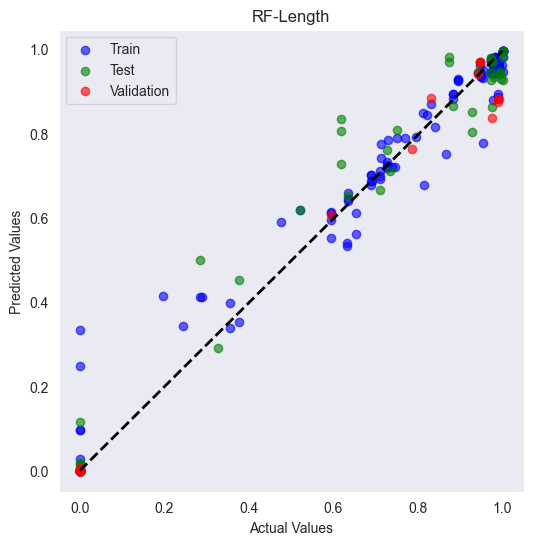

In [41]:
def scatter_plots(model_name, y_pred_train, y_pred_test,y_pred_val, y_train, y_test, y_val):  
    # 设置图的大小  
    plt.figure(figsize=(6, 6))  
      
    # 在同一个图中绘制所有点的散点图  
    plt.scatter(y_train, y_pred_train, color='blue', label='Train', alpha=0.6)  
    plt.scatter(y_test, y_pred_test, color='green', label='Test', alpha=0.6)  
    plt.scatter(y_val, y_pred_val, color='red', label='Validation', alpha=0.6)  
      
    # 绘制完美拟合线  
    limits = [  
        min(y_train.min(), y_test.min(), y_val.min()),  # x min  
        max(y_train.max(), y_test.max(), y_val.max()),  # x max  
        min(y_pred_train.min(), y_pred_test.min(), y_pred_val.min()),  # y min  
        max(y_pred_train.max(), y_pred_test.max(), y_pred_val.max()),  # y max  
    ]  
    plt.plot(limits[:2], limits[2:], 'k--', lw=2)  

    # 设置图的标题和坐标轴标签  
    plt.title('RF-Length')  
    plt.xlabel('Actual Values')  
    plt.ylabel('Predicted Values')  
    # 禁用网格  
    plt.grid(False)  
    # 显示图例  
    plt.legend()  
      
    # 显示图形  
    plt.show()  

# 调用scatter_plots函数  
scatter_plots('rf', y_pred_train, y_pred_test, y_pred_val, y_train, y_test, y_val)


In [42]:
import pickle
# save RF model
model_name = 'rf.pkl' # 模型名称.plk
path =''
with open(path+'rf.pkl','wb') as f:
    pickle.dump(rf, f)

In [43]:
#y_train

In [44]:
#y_pred_train

In [45]:
#y_test

In [46]:
#y_pred_test

In [47]:
#y_val

In [48]:
#y_pred_val

In [49]:
#将这些特征值放入一个列表中，注意这是一个二维列表，即使只有一个样本  
new_data = np.array( [ [ 350,
                         75,
                         175,
                         350,
                         50,
                         15,
                         5,
                         3.33,
                         10000,
                         1,
                         0.9,
                         535,
                         41.66612502,
                         4.952834746,
                         8.651267307,
                         9.516906684
                        ] ] )# 列表中的列表，每个内部列表代表一个样本  
# 使用训练时相同的scaler对new_data进行标准化  
new_data_scaled = zscore.transform(new_data)  
# 使用模型进行预测  
prediction = rf.predict(new_data_scaled)  
print(prediction)  # 因为只有一个样本，所以prediction将是一个包含单个预测值的数组

[0.82322918]


D:\Python\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


#   PDP

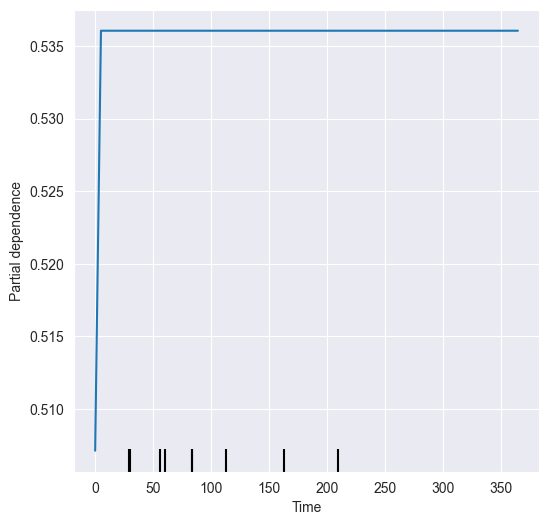

In [50]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

x_train, x_test_val, y_train, y_test_val = train_test_split(xx, yy, shuffle=True,test_size=0.3, random_state=1)
    #x_训练集，x_测试验证集，y_训练集，y_测试验证集                    划分前将数据集进行随机打乱，并按照7：3划分，且划分方式统一
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, shuffle=True,test_size=0.25, random_state=1)
    #x_测试集，x_验证集，y_测试集，y_验证集                           划分前将数据集进行随机打乱，并按照3：1划分，且划分方式统一
    
feature_names = ['Time', 'Deep', 'Length', 'HRT', 'COD', 'TN', 'NH4-N', 'C/N', 'c(A)', 'CSC', 'XLogP3', 'WI', 'RA(P)', 'RA(F)', 'RA(B)', 'RA(A)']  

feat_name = ('Time')
PartialDependenceDisplay.from_estimator(rf, x_train, [feat_name])
plt.gcf().set_size_inches(6, 6)  # w 是宽度，h 是高度  
plt.show()

In [51]:
from pycebox.ice import ice, ice_plot

# 假设您已经训练了随机森林模型，并且准备好特征和目标变量

feature_names = ['Time', 'Deep', 'Length', 'HRT', 'COD', 'TN', 'NH4-N', 'C/N', 'c(A)', 'CSC', 'XLogP3', 'WI', 'RA(P)', 'RA(F)',                  'RA(B)', 'RA(A)']  
# 选择一个特征来生成ICE图
feature_of_interest = ('Time')

# 使用pycebox生成ICE数据
ice_df = ice(xx, feature_of_interest, rf.predict, num_grid_points=20)

# 使用pycebox绘制ICE图
ice_plot(ice_df, c='dimgray', linewidth=0.5, plot_pdp=True, plot_points=True)


ModuleNotFoundError: No module named 'pycebox'